In [43]:
import os
import sys
#sys.path.append(os.path.join(os.getcwd(), '..'))
from ldm.data.deepfashion import DeepFashionSMPL
#from ldm.util import instantiate_from_config
from einops import rearrange
import matplotlib.pyplot as plt
from collections import namedtuple
from copy import deepcopy

import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from torchvision import transforms as T
from pathlib import Path
from skimage.metrics import structural_similarity as ssim

from ldm.data.segm_utils import LipSegmenter
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import json
import pickle

In [ ]:
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)
    model.eval()
    return model

In [2]:
device = 'cuda:0'
CKPT = 'logs/2023-01-31T02-39-11_inshop_lip_clip/checkpoints/epoch=000007.ckpt'
CONFIG = 'configs/deepfashion/inshop_lip_clip.yaml'

config = OmegaConf.load(CONFIG)
model = load_model_from_config(config, f"{CKPT}").to(device)

Loading model from logs/2023-01-31T02-39-11_inshop_lip_clip/checkpoints/epoch=000007.ckpt
Global Step: 49921
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 425.29 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/kl-f8-deepfashion/deepfashion_inshop_256.ckpt


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.14.self_attn.v_proj.weight', 'vision_model.encoder.layers.9.mlp.fc1.bias', 'vision_model.encoder.layers.6.self_attn.k_proj.bias', 'vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_model.encoder.layers.12.layer_norm1.bias', 'vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_model.encoder.layers.1.self_attn.k_proj.weight', 'vision_model.encoder.layers.23.self_attn.out_proj.bias', 'text_projection.weight', 'vision_model.encoder.layers.19.mlp.fc2.bias', 'vision_model.encoder.layers.5.self_attn.k_proj.bias', 'vision_model.encoder.layers.5.mlp.fc1.weight', 'vision_model.encoder.layers.13.self_attn.v_proj.weight', 'vision_model.encoder.layers.5.mlp.fc1.bias', 'vision_model.encoder.layers.21.layer_norm1.weight', 'vision_model.encoder.layers.22.mlp.fc1.bias', 'vision_model.encoder.layers.14.layer_norm2.weight', 'vision_model.encoder.layers.6

In [7]:
config['data']['params']['test']['params']

{'folder': '/home/soon/datasets/deepfashion_inshop', 'image_dir': 'img_256', 'data_file': 'test.csv', 'pair_file': ['pairs-test-all.csv']}

In [24]:
root =  Path('/home/soon/datasets/deepfashion_inshop')
image_root = root/'img_256'
pose_root = root/'smpl_256'
style_root = root/'styles'
captions = json.load(open(root/'captions.json'))


df = pd.read_csv('test.csv').drop(columns=['Unnamed: 0']).set_index('image')

In [30]:
image_id = 'MEN/Shirts_Polos/id_00001802/02_4_full.jpg'

def get_text(image_id):
    return captions[df.loc[image_id]['text']]

get_text(image_id)

'This person wears a short-sleeve T-shirt with graphic patterns and a long trousers. The T-shirt is with cotton fabric and its neckline is lapel. The trousers are with cotton fabric and pure color patterns.'

In [ ]:
def get_pose(image_id):
    pose_path = str(pose_root/df.loc[image_id]['pose'])

    smpl_image_file = pose_path + '.jpg'
    smpl_file = pose_path + '.p'    
smpl_image = self.smpl_image_transform(Image.open(smpl_image_file))    

In [20]:
df.loc['MEN/Shirts_Polos/id_00001802/02_4_full.jpg']

styles        MEN/Shirts_Polos/id_00001802/02/4_full
pose          MEN/Shirts_Polos/id_00001802/02_4_full
text      MEN-Shirts_Polos-id_00001802-02_4_full.jpg
Name: MEN/Shirts_Polos/id_00001802/02_4_full.jpg, dtype: object

In [41]:
style_names = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']


class DeepFashionSample(Dataset):
    
    def __init__(self, 
                folder,
                image_dir,
                pair_file, # from, to 
                data_file, # point to style features and text
                image_sizes=None, 
                pad=None,
                input_mask_type='mask',
                **kwargs):
        super().__init__(**kwargs)
        assert input_mask_type in ['mask', 'smpl']
        self.input_mask_type = input_mask_type
        self.root = Path(folder)
        self.image_root = self.root/image_dir
        self.pose_root = self.root/'smpl_256' if self.input_mask_type=='mask' else self.root/'smpl'
        self.style_root = self.root/'styles'
        self.segm_root = self.root/'lip_segm_256'
        self.texts = json.load(open(self.root/'captions.json'))
        self.map_df = pd.read_csv(data_file)
        self.map_df.set_index('image', inplace=True)

        dfs = [pd.read_csv(f) for f in pair_file]
        self.df = pd.concat(dfs, ignore_index=True)
        
        ''' pad and resize '''
        self.image_sizes = image_sizes
        transform_list = [T.Resize(image_sizes)] if image_sizes else []
        self.image_transform = T.Compose(transform_list + [
            T.ToTensor(),
            T.Lambda(lambda x: rearrange(x * 2. - 1., 'c h w -> h w c'))])

        self.pad = None if pad is None else tuple(pad)
        ''' '''

        self.clip_norm = T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), 
                                    std=(0.26862954, 0.26130258, 0.27577711))
        self.clip_transform = T.Compose([
            T.ToTensor(),
            self.clip_norm
        ])


        self.loss_w_transform = T.Compose([
            T.Resize(size=(32,24), interpolation=T.InterpolationMode.NEAREST),    
            T.ToTensor(),
        ])    
        
        if self.input_mask_type=='mask':
            self.mask_transform = T.Compose([
                T.Resize(size=(32,24), interpolation=T.InterpolationMode.NEAREST),    
                T.ToTensor(),
                T.Lambda(lambda x: x * 2. - 1.)
            ])                
        else :
            self.mask_transform = T.Compose([
                T.Resize(size=(32,24), interpolation=T.InterpolationMode.NEAREST),    
                T.ToTensor(),
                T.Lambda(lambda x: torch.mean(x,0, keepdim=True)  * 2. - 1.)
            ])             

        self.smpl_image_transform = T.Compose([
            #T.Resize(size=256),
            T.CenterCrop(size=(256, 192))])
        
        self.segmenter = LipSegmenter(self.clip_transform)
        self.style_names = style_names

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        # source - get fashion styles
        source = self.map_df.loc[index]
        src_path = str(self.image_root/source.name)
        source_image = Image.open(src_path)

        #styles_dict = self.segmenter.forward(source_image, segm)
        #styles = torch.stack(list(styles_dict.values()))            
        styles_path = source['styles']

        
        style_images = []
        for style_name in self.style_names:
            f_path = self.style_root/styles_path/f'{style_name}.jpg'

            if f_path.exists():
                style_image = self.clip_transform((Image.open(f_path)))
            else:
                style_image = self.clip_norm(torch.zeros(3, 224, 224))
            style_images.append(style_image)
        style_images = torch.stack(style_images)  


        data = {#"fname": fname, 
                "src_image": self.image_transform(source_image),
                "styles": style_images}

        # target - get text, person_mask, pose, 
        target = self.map_df.loc[index]

        text = self.texts.get(target.text, '')

        target_path = str(self.image_root/target.name)
        target_image = self.image_transform(Image.open(target_path))

        data.update({"image": target_image, "txt": text,})

        # image
        #if self.pad:
        #    image = T.Pad(self.pad, padding_mode='edge')(image)

        # SMPL            
        pose_path = str(self.pose_root/target.pose)
        smpl_image_file = pose_path + '.jpg'
        smpl_file = pose_path + '.p'
        smpl_image = self.smpl_image_transform(Image.open(smpl_image_file))
        if self.input_mask_type=='mask':
            mask_file = pose_path + '_mask.png'
            mask_image = Image.open(mask_file)
            person_mask = self.mask_transform(mask_image)
        else:
            person_mask = self.mask_transform(smpl_image)

        smpl_image = self.image_transform(smpl_image)

        with open(smpl_file, 'rb') as f:
            smpl_params = pickle.load(f)
            pred_pose = smpl_params[0]['pred_body_pose']
            pred_betas = smpl_params[0]['pred_betas']
            pred_camera = np.expand_dims(smpl_params[0]['pred_camera'], 0)
            smpl_pose = np.concatenate((pred_pose, pred_betas, pred_camera), axis=1)
            smpl_pose = T.ToTensor()(smpl_pose).view((1,-1))


        segm_path = str(self.segm_root/target.name).replace('.jpg','.png')            
        segm = np.array(Image.open(segm_path))

        #person_mask = self.segmenter.get_mask(segm, {'background':0.0}, default_value=1.0)
        loss_weight = self.segmenter.get_mask(segm, 
                                    {'background':0.5, 
                                    'left-arm':2.0, 
                                    'right-arm':2.0, 
                                    'face':5.0})
        loss_weight = self.loss_w_transform(Image.fromarray(loss_weight))


        data.update({'smpl':smpl_pose, 
                     'smpl_image':smpl_image, 
                     'person_mask':person_mask,
                     'loss_w':loss_weight})


        return data



ds = DeepFashionSample(**config['data']['params']['test']['params'])


In [45]:
ds[image_id]['src_image'].shape

torch.Size([256, 192, 3])

In [46]:
def generate(model, batch, steps=200):
    for k, v in batch.items():
        if type(v)==torch.Tensor:
            batch[k] = batch[k].unsqueeze(0).to(device)
        else:
            batch[k] = [batch[k]]

    with torch.no_grad():
        images = model.log_images(batch, ddim_steps=steps, 
                                  unconditional_guidance_scale=3.,
                                  unconditional_guidance_label=["txt"])
        
    for k in images:
        images[k] = images[k].detach().cpu()
        images[k] = torch.clamp(images[k], -1., 1.)
        images[k] = rearrange(images[k].numpy(),'b c h w -> b h w c') *0.5 + 0.5
    return images


def draw_styles(style_batch):
    
    style_names = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']

    denorm = T.Compose([ T.Normalize(mean = [ 0., 0., 0. ],  std = [ 1/0.226862954, 1/0.26130258, 1/0.27577711 ]),
                         T.Normalize(mean = [ -0.48145466, -0.4578275, -0.40821073], std = [ 1., 1., 1. ]),      ])
    rows, cols = 2, 4
    fig, axs = plt.subplots(rows, cols)
    fig.set_figheight(8)
    fig.set_figwidth(16)
    for i, (name, style) in enumerate(zip(style_names[:-1], style_batch[:-1])):
        row = i//cols
        col = i%cols
        axs[row, col].imshow(T.ToPILImage()(denorm(style)))
        axs[row, col].set_title(name)
        axs[row, col].axis('off')
    plt.show()
            

In [88]:
import re
def convert_fname(long_name):
    #input_list = ['WOMENShortsid0000478403_4full','WOMENBlouses_Shirtsid0000311501_2side','WOMENShortsid0000478403_4full','WOMENShortsid0000478403_1front']
    input_list = long_name.replace('fashion','').split('___')
    # Define a regular expression pattern to match the relevant parts of each input string
    pattern = r'WOMEN(\w+)id(\d+)_(\d)(\w+)'

    # Use a list comprehension to extract the matching substrings from each input string, and format them into the desired output format
    output_list = [f'WOMEN/{category}/id_{id_num[:8]}/{id_num[8:]}_{view_num}_{view_desc}' for (category, id_num, view_num, view_desc) in re.findall(pattern, ' '.join(input_list))]

    # Print the resulting list of formatted strings
    return output_list

#convert_fname('fashionWOMENShortsid0000478403_4full___fashionWOMENShortsid0000478403_1front')
convert_fname('fashionWOMENBlouses_Shirtsid0000311501_7additional___fashionWOMENBlouses_Shirtsid0000311501_2side')

['WOMEN/Blouses_Shirts/id_00003115/01_7_additional',
 'WOMEN/Blouses_Shirts/id_00003115/01_2_side']

In [92]:
src_id = 'WOMEN/Shorts/id_00004784/03_4_full.jpg'
dst_id = 'WOMEN/Shorts/id_00004784/03_1_front.jpg'

src_id = 'WOMEN/Shorts/id_00004784/03_4_full.jpg'
dst_id = 'WOMEN/Shorts/id_00004784/03_1_front.jpg'

src_batch = ds[src_id]
dst_batch = ds[dst_id]

dst_batch['txt'] = src_batch['txt']
dst_batch['styles'] = src_batch['styles']

list_jacket = ['fashionWOMENShortsid0000478403_4full___fashionWOMENShortsid0000478403_1front.png',
'fashionWOMENBlouses_Shirtsid0000311501_7additional___fashionWOMENBlouses_Shirtsid0000311501_2side.png',
               'fashionWOMENTees_Tanksid0000298802_4full___fashionWOMENTees_Tanksid0000298802_1front.png',
#'fashionWOMENTees_Tanksid0000788404_4full___fashionWOMENTees_Tanksid0000788404_2side.png',
'fashionWOMENTees_Tanksid0000397106_7additional___fashionWOMENTees_Tanksid0000397106_1front.png',
              'fashionWOMENTees_Tanksid0000664503_4full___fashionWOMENTees_Tanksid0000664503_3back.png',
              'fashionWOMENDressesid0000651901_4full___fashionWOMENDressesid0000651901_2side.png']

WOMEN/Dresses/id_00006519/01_4_full WOMEN/Dresses/id_00006519/01_2_side
Plotting: Switched to EMA weights
Data shape for DDIM sampling is (1, 4, 32, 24), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|████████████████████████| 200/200 [00:44<00:00,  4.50it/s]


Plotting: Restored training weights


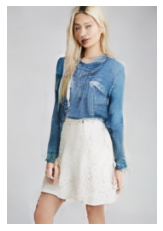

In [194]:
folder = "./figures/face_edit"

for j in list_jacket[5:6]:
    src_id, dst_id = convert_fname(j.split('.')[0])
    src_batch = ds[src_id+'.jpg']
    dst_batch = ds[dst_id+'.jpg']
    print(src_id, dst_id)
    dst_batch['txt'] = src_batch['txt']
    dst_batch['styles'] = src_batch['styles']
    #dst_batch['txt'] = 'Her shirt has long sleeves, cotton fabric and graphic patterns. The outer clothing the female wears is with chiffon fabric and pure color patterns. The neckline of it is crew. The pants this woman wears is of three-point length. The pants are with denim fabric and pure color patterns. The outer clothing the female wears is with chiffon fabric and pure color patterns. There is a ring on her finger. There is an accessory in his her neck.'
    #dst_batch['txt'] = 'The sweater this lady wears has long sleeves and its fabric is cotton. The pattern of it is pure color. It has a lapel neckline. This lady wears a long trousers, with denim fabric and solid color patterns. This person also wears an outer clothing, with cotton fabric and solid color patterns.'
    
    #This person also wears an outer clothing, with cotton fabric and solid color patterns
    log = generate(model, dst_batch, 200)

    sample = T.CenterCrop(size=(256, 176))(Image.fromarray(np.uint8(log['samples'][0]*255)))
    #sample.save(os.path.join(folder, j))
    plt.imshow(sample)
    plt.axis('off')
    plt.show()



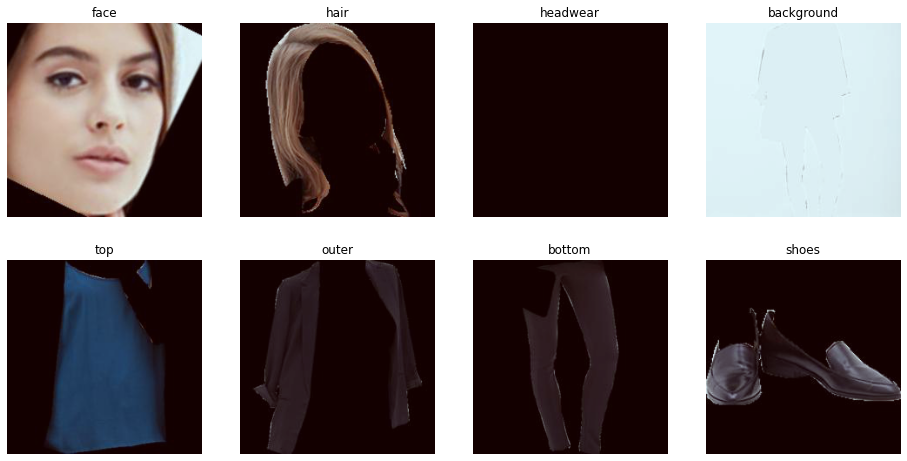

In [183]:
draw_styles(src_batch['styles'])

In [192]:
sample.save(os.path.join(folder, j))

In [164]:
captions['WOMEN-Jackets_Coats-id_00000069-04_7_additional.jpg']

'This female is wearing a long-sleeve shirt with pure color patterns. The shirt is with cotton fabric. It has a round neckline. This female wears a long trousers. The trousers are with cotton fabric and pure color patterns. This person also wears an outer clothing, with cotton fabric and solid color patterns. The lady is wearing a ring on her finger.'

In [187]:
src_batch['txt']

'This person is wearing a long-sleeve shirt with graphic patterns and a three-point shorts. The shirt is with cotton fabric. The neckline of the shirt is crew. The shorts are with cotton fabric and graphic patterns. The outer clothing is with denim fabric and solid color patterns.'

In [189]:
dst_batch['txt']

['This person is wearing a long-sleeve shirt with graphic patterns and a three-point shorts. The shirt is with cotton fabric. The neckline of the shirt is crew. The shorts are with cotton fabric and graphic patterns. The outer clothing is with denim fabric and solid color patterns.']